In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import print_function
import gzip
import itertools
import pickle
import os
import sys
import numpy as np
import lasagne
import theano
import theano.tensor as T
import time
from sklearn.externals import joblib

In [2]:
NUM_EPOCHS = 500
BATCH_SIZE = 600
NUM_HIDDEN_UNITS = 512
LEARNING_RATE = 0.01
MOMENTUM = 0.9

In [3]:
def create_iter_functions(dataset, output_layer,
                          X_tensor_type=T.matrix,
                          batch_size=BATCH_SIZE,
                          learning_rate=LEARNING_RATE, momentum=MOMENTUM):
    """Create functions for training, validation and testing to iterate one
       epoch.
    """
    batch_index = T.iscalar('batch_index')
    X_batch = X_tensor_type('x')
    y_batch = T.ivector('y')
    batch_slice = slice(batch_index * batch_size,
                        (batch_index + 1) * batch_size)

    objective = lasagne.objectives.Objective(output_layer,
        loss_function=lasagne.objectives.categorical_crossentropy)

    loss_train = objective.get_loss(X_batch, target=y_batch)
    loss_eval = objective.get_loss(X_batch, target=y_batch,
                                   deterministic=True)

    pred = T.argmax(
        lasagne.layers.get_output(output_layer, X_batch, deterministic=True),
        axis=1)
    accuracy = T.mean(T.eq(pred, y_batch), dtype=theano.config.floatX)

    all_params = lasagne.layers.get_all_params(output_layer)
    updates = lasagne.updates.nesterov_momentum(
        loss_train, all_params, learning_rate, momentum)

    iter_train = theano.function(
        [batch_index], loss_train,
        updates=updates,
        givens={
            X_batch: dataset['X_train'][batch_slice],
            y_batch: dataset['y_train'][batch_slice],
        },
    )

    iter_valid = theano.function(
        [batch_index], [loss_eval, accuracy],
        givens={
            X_batch: dataset['X_valid'][batch_slice],
            y_batch: dataset['y_valid'][batch_slice],
        },
    )

    iter_test = theano.function(
        [batch_index], [loss_eval, accuracy],
        givens={
            X_batch: dataset['X_test'][batch_slice],
            y_batch: dataset['y_test'][batch_slice],
        },
    )

    return dict(
        train=iter_train,
        valid=iter_valid,
        test=iter_test,
    )

In [4]:
def train(iter_funcs, dataset, batch_size=BATCH_SIZE):
    """Train the model with `dataset` with mini-batch training. Each
       mini-batch has `batch_size` recordings.
    """
    num_batches_train = dataset['num_examples_train'] // batch_size
    num_batches_valid = dataset['num_examples_valid'] // batch_size

    for epoch in itertools.count(1):
        batch_train_losses = []
        for b in range(num_batches_train):
            batch_train_loss = iter_funcs['train'](b)
            batch_train_losses.append(batch_train_loss)

        avg_train_loss = np.mean(batch_train_losses)

        batch_valid_losses = []
        batch_valid_accuracies = []
        for b in range(num_batches_valid):
            batch_valid_loss, batch_valid_accuracy = iter_funcs['valid'](b)
            batch_valid_losses.append(batch_valid_loss)
            batch_valid_accuracies.append(batch_valid_accuracy)

        avg_valid_loss = np.mean(batch_valid_losses)
        avg_valid_accuracy = np.mean(batch_valid_accuracies)

        yield {
            'number': epoch,
            'train_loss': avg_train_loss,
            'valid_loss': avg_valid_loss,
            'valid_accuracy': avg_valid_accuracy,
        }

In [5]:
def load_data(features, labels):
    """Get data with labels, split into training, validation and test set."""
    X_train = features[:4000]
    y_train = labels[:4000]
    X_valid = features[4000:5000]
    y_valid = labels[4000:5000]
    X_test = features[5000:]
    y_test = labels[5000:]

    # reshape for convolutions
    X_train = X_train.reshape((X_train.shape[0], 1, 28, 28))
    X_valid = X_valid.reshape((X_valid.shape[0], 1, 28, 28))
    X_test = X_test.reshape((X_test.shape[0], 1, 28, 28))

    return dict(
        X_train=theano.shared(lasagne.utils.floatX(X_train)),
        y_train=T.cast(theano.shared(y_train), 'int32'),
        X_valid=theano.shared(lasagne.utils.floatX(X_valid)),
        y_valid=T.cast(theano.shared(y_valid), 'int32'),
        X_test=theano.shared(lasagne.utils.floatX(X_test)),
        y_test=T.cast(theano.shared(y_test), 'int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=9,
        )

In [6]:
def scale(X, eps = 0.001):
    # scale the data points s.t the columns of the feature space
    # (i.e the predictors) are within the range [0, 1]
    return (X - np.min(X, axis = 0)) / (np.max(X, axis = 0) + eps)

In [7]:
def build_model(input_width, input_height, output_dim,
                batch_size=BATCH_SIZE):
    l_in = lasagne.layers.InputLayer(
        shape=(batch_size, 1, input_width, input_height),
        )

    l_conv1 = lasagne.layers.Conv2DLayer(
        l_in,
        num_filters=32,
        filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform(),
        )
    l_pool1 = lasagne.layers.MaxPool2DLayer(l_conv1, pool_size=(2, 2))

    l_conv2 = lasagne.layers.Conv2DLayer(
        l_pool1,
        num_filters=32,
        filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform(),
        )
    l_pool2 = lasagne.layers.MaxPool2DLayer(l_conv2, pool_size=(2, 2))

    l_hidden1 = lasagne.layers.DenseLayer(
        l_pool2,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform(),
        )

    l_hidden1_dropout = lasagne.layers.DropoutLayer(l_hidden1, p=0.5)

    l_hidden2 = lasagne.layers.DenseLayer(
        l_hidden1_dropout,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        )
    l_hidden2_dropout = lasagne.layers.DropoutLayer(l_hidden2, p=0.5)

    l_out = lasagne.layers.DenseLayer(
        l_hidden1_dropout,
        num_units=output_dim,
        nonlinearity=lasagne.nonlinearities.softmax,
        W=lasagne.init.GlorotUniform(),
        )

    return l_out

In [8]:
features = joblib.load("./mldata/features_1200.mat")
labels = joblib.load("./mldata/lables_1200.mat")

features = features.astype("float32")
features = scale(features)
labels = np.array(labels, 'int')

dataset = load_data(features, labels)

print("Building model and compiling functions...")
output_layer = build_model(
    input_height=dataset['input_height'], # 28
    input_width=dataset['input_width'], # 28
    output_dim=dataset['output_dim'], # 9
    )

iter_funcs = create_iter_functions(
    dataset,
    output_layer,
    X_tensor_type=T.tensor4,
    )

num_epochs = NUM_EPOCHS

print("Starting training...")
now = time.time()
try:
    for epoch in train(iter_funcs, dataset):
        print("Epoch {} of {} took {:.3f}s".format(
            epoch['number'], num_epochs, time.time() - now))
        now = time.time()
        print("  training loss:\t\t{:.6f}".format(epoch['train_loss']))
        print("  validation loss:\t\t{:.6f}".format(epoch['valid_loss']))
        print("  validation accuracy:\t\t{:.2f} %%".format(
            epoch['valid_accuracy'] * 100))

        if epoch['number'] >= num_epochs:
            break

except KeyboardInterrupt:
    pass    

Building model and compiling functions...
Starting training...
Epoch 1 of 500 took 15.613s
  training loss:		2.177750
  validation loss:		2.133109
  validation accuracy:		23.83 %%
Epoch 2 of 500 took 14.688s
  training loss:		2.095396
  validation loss:		1.981853
  validation accuracy:		56.00 %%
Epoch 3 of 500 took 15.201s
  training loss:		1.883777
  validation loss:		1.566939
  validation accuracy:		78.17 %%
Epoch 4 of 500 took 15.075s
  training loss:		1.387538
  validation loss:		0.876188
  validation accuracy:		78.67 %%
Epoch 5 of 500 took 14.715s
  training loss:		0.839850
  validation loss:		0.568517
  validation accuracy:		87.33 %%
Epoch 6 of 500 took 14.691s
  training loss:		0.602313
  validation loss:		0.513653
  validation accuracy:		89.50 %%
Epoch 7 of 500 took 14.697s
  training loss:		0.512030
  validation loss:		0.492230
  validation accuracy:		89.33 %%
Epoch 8 of 500 took 15.350s
  training loss:		0.454129
  validation loss:		0.468695
  validation accuracy:		89.50 %%
E

/Users/dikien/anaconda/lib/python2.7/site-packages/Lasagne-0.1.dev0-py2.7.egg/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/Users/dikien/anaconda/lib/python2.7/site-packages/Lasagne-0.1.dev0-py2.7.egg/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


In [9]:
features = joblib.load("./mldata/features_1200.mat")
labels = joblib.load("./mldata/lables_1200.mat")

features = features.astype("float32")
features = scale(features)
labels = np.array(labels, 'int')

unique_train, counts_train = np.unique(labels[:4000], return_counts=True)
unique_valid, counts_valid = np.unique(labels[4000:5000], return_counts=True)
unique_test, counts_test = np.unique(labels[5000:], return_counts=True)

print ("train set")
print ("{}".format(np.asarray((unique_train, counts_train)).T))
print ("test set")
print ("{}".format(np.asarray((unique_valid, counts_valid)).T))
print ("validation set")
print ("{}".format(np.asarray((unique_test, counts_test)).T))

train set
[[  0 423]
 [  1 619]
 [  2 383]
 [  3 404]
 [  4 478]
 [  5 425]
 [  6 259]
 [  7 551]
 [  8 458]]
test set
[[  0 114]
 [  1 172]
 [  2 101]
 [  3  95]
 [  4 127]
 [  5  85]
 [  6  54]
 [  7 141]
 [  8 111]]
validation set
[[  0 103]
 [  1 130]
 [  2 132]
 [  3  94]
 [  4 134]
 [  5 109]
 [  6  57]
 [  7 148]
 [  8  93]]


(array([ 423.,  619.,  383.,  404.,  478.,  425.,  259.,  551.,  458.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

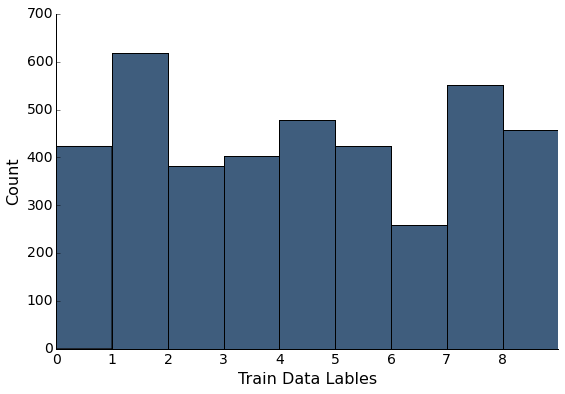

In [17]:
plt.figure(figsize=(9, 6))

# Remove the plot frame lines. They are unnecessary chartjunk.  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

# Make sure your axis ticks are large enough to be easily read.  
# You don't want your viewers squinting to read your plot.  
plt.xticks(unique_train, fontsize=14)  
plt.yticks(fontsize=14)  

# Along the same vein, make sure your axis labels are large  
# enough to be easily read as well. Make them slightly larger  
# than your axis tick labels so they stand out.  
plt.xlabel("Train Data Lables", fontsize=16)  
plt.ylabel("Count", fontsize=16)

ax.hist(labels[:4000], bins=range(10), cumulative=False, color="#3F5D7D")

(array([ 114.,  172.,  101.,   95.,  127.,   85.,   54.,  141.,  111.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

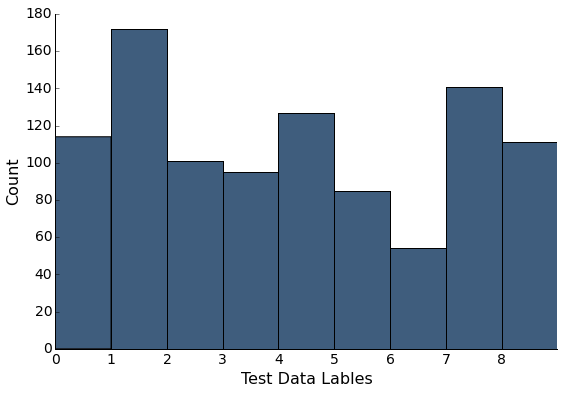

In [19]:
plt.figure(figsize=(9, 6))

# Remove the plot frame lines. They are unnecessary chartjunk.  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

# Make sure your axis ticks are large enough to be easily read.  
# You don't want your viewers squinting to read your plot.  
plt.xticks(unique_test, fontsize=14)  
plt.yticks(fontsize=14)  

# Along the same vein, make sure your axis labels are large  
# enough to be easily read as well. Make them slightly larger  
# than your axis tick labels so they stand out.  
plt.xlabel("Test Data Lables", fontsize=16)  
plt.ylabel("Count", fontsize=16)

ax.hist(labels[4000:5000], bins=range(10), cumulative=False, color="#3F5D7D")

(array([ 103.,  130.,  132.,   94.,  134.,  109.,   57.,  148.,   93.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

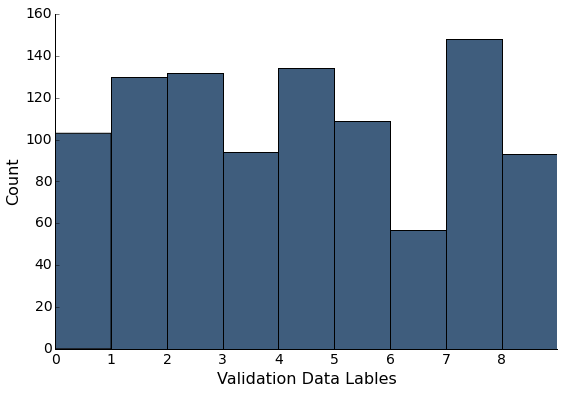

In [20]:
plt.figure(figsize=(9, 6))

# Remove the plot frame lines. They are unnecessary chartjunk.  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

# Make sure your axis ticks are large enough to be easily read.  
# You don't want your viewers squinting to read your plot.  
plt.xticks(unique_valid, fontsize=14)  
plt.yticks(fontsize=14)  

# Along the same vein, make sure your axis labels are large  
# enough to be easily read as well. Make them slightly larger  
# than your axis tick labels so they stand out.  
plt.xlabel("Validation Data Lables", fontsize=16)  
plt.ylabel("Count", fontsize=16)

ax.hist(labels[5000:], bins=range(10), cumulative=False, color="#3F5D7D")